# Cluster Installations

In [1]:
!pip install -q kaggle
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 104.6 MB/s eta 0:00:00


# Upload Kaggle API Key
Upload and move kaggle API key to the "/root/.config/kaggle" directory and give it executable permissions

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"adityasabu","key":"ce50f17c90caaf427d2004c144f88090"}'}

In [3]:
!mkdir /root/.config/kaggle/
!mv kaggle.json /root/.config/kaggle/
!chmod 600 /root/.config/kaggle/kaggle.json

# Dataset Retrievals
Download all of the kaggle datasets to be used to train the model

In [4]:
!kaggle datasets download -d devildyno/email-spam-or-not-classification -p /content
!unzip /content/email-spam-or-not-classification.zip -d /content

!kaggle datasets download -d meruvulikith/190k-spam-ham-email-dataset-for-classification -p /content
!unzip /content/190k-spam-ham-email-dataset-for-classification.zip -d /content

!kaggle datasets download -d yasserh/spamemailsdataset -p /content
!unzip /content/spamemailsdataset.zip -d /content

!kaggle datasets download -d venky73/spam-mails-dataset -p /content
!unzip /content/spam-mails-dataset.zip -d /content

!kaggle datasets download -d ozlerhakan/spam-or-not-spam-dataset -p /content
!unzip /content/spam-or-not-spam-dataset.zip -d /content

!kaggle datasets download -d tapakah68/email-spam-classification -p /content
!unzip /content/email-spam-classification.zip -d /content

!kaggle datasets download -d mohinurabdurahimova/maildataset -p /content
!unzip /content/maildataset.zip -d /content

Dataset URL: https://www.kaggle.com/datasets/devildyno/email-spam-or-not-classification
License(s): CC0-1.0
  0% 0.00/50.8k [00:00<?, ?B/s]
100% 50.8k/50.8k [00:00<00:00, 248MB/s]
Archive:  /content/email-spam-or-not-classification.zip
  inflating: /content/spam_dataset.csv  
Dataset URL: https://www.kaggle.com/datasets/meruvulikith/190k-spam-ham-email-dataset-for-classification
License(s): MIT
  0% 0.00/107M [00:00<?, ?B/s]
100% 107M/107M [00:00<00:00, 3.04GB/s]
Archive:  /content/190k-spam-ham-email-dataset-for-classification.zip
  inflating: /content/spam_Emails_data.csv  
Dataset URL: https://www.kaggle.com/datasets/yasserh/spamemailsdataset
License(s): CC0-1.0
  0% 0.00/127k [00:00<?, ?B/s]
100% 127k/127k [00:00<00:00, 452MB/s]
Archive:  /content/spamemailsdataset.zip
  inflating: /content/Spam.csv       
Dataset URL: https://www.kaggle.com/datasets/venky73/spam-mails-dataset
License(s): CC0-1.0
  0% 0.00/1.86M [00:00<?, ?B/s]
100% 1.86M/1.86M [00:00<00:00, 1.38GB/s]
Archive:  /co

# Library Installations
Install all libraries used for model creation and visualization

In [5]:
import os
import pandas as pd
import re
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing

In [6]:
# Save datasets as a pandas DataFrame
df_1 = pd.read_csv("/content/spam_ham_dataset.csv")
df_2 = pd.read_csv("/content/spam_Emails_data.csv")
df_3 = pd.read_csv("/content/spam_dataset.csv")
df_4 = pd.read_csv('/content/mail_data.csv')
df_5 = pd.read_csv('/content/email_spam.csv')


In [7]:
def clean_df(df, spam_values=None, not_spam_values=None):
  """
  Clean and normalize a raw DataFrame for binary spam classification.

  This function
    1) Automatically detects the text and label columns in a
       DataFrame
    2) Standardizes them to a common schema(`text`, `label`)
    3) Normalizes labels to binary values (1 = spam,0 = not spam)
    4) Applies basic text preprocessing.

  Rows with unknown or invalid labels are removed.


  Parameters
  ----------
  df : pandas.DataFrame
      Input DataFrame containing raw text data and corresponding labels.

  spam_values : list, optional
      List of values that should be interpreted as spam labels.
      Values are compared in a case-insensitive manner after string
      conversion. Defaults include common representations such as
      ["spam", "1", 1, True, "yes", "true", "positive"].

  not_spam_values : list, optional
      List of values that should be interpreted as non-spam (ham) labels.
      Values are compared in a case-insensitive manner after string
      conversion. Defaults include common representations such as
      ["ham", "0", 0, False, "no", "false", "negative", "not spam"].

  Returns
  -------
  pandas.DataFrame
      A cleaned DataFrame with two columns:
      - `text`  : Preprocessed text data (lowercased, URLs and punctuation removed)
      - `label` : Integer binary labels (1 = spam, 0 = not spam)

  Rows with unrecognized labels are excluded, and the index is reset.

  """
  # Normalize column names
  df.columns = [str(c).lower() for c in df.columns]

  # Detect text column
  obj_cols = df.select_dtypes(include="object").columns.tolist()
  if obj_cols:
      # Choose the column with longest average string length
      text_col = df[obj_cols].apply(lambda x: x.str.len().mean()).idxmax()
  else:
      # fallback: take first column
      text_col = df.columns[0]

  # Detect label column: pick column with fewest unique values excluding text_col
  possible_label_cols = [c for c in df.columns if c != text_col]
  if possible_label_cols:
      label_col = df[possible_label_cols].nunique().idxmin()
  else:
      # fallback: second column or the same as text
      label_col = df.columns[1] if len(df.columns) > 1 else df.columns[0]

  # Select and rename
  df = df[[text_col, label_col]].rename(columns={text_col: "text", label_col: "label"})
  df["text"] = df["text"].astype(str)

  # Default spam/ham values
  if spam_values is None:
      spam_values = ["spam", "1", 1, True, "yes", "true", "positive"]
  if not_spam_values is None:
      not_spam_values = ["ham", "0", 0, False, "no", "false", "negative", "not spam"]

  # Normalize labels
  df["label"] = df["label"].astype(str).str.lower().map(
      lambda x: 1 if x in [str(v).lower() for v in spam_values]
      else (0 if x in [str(v).lower() for v in not_spam_values] else None)
  )

  # Drop unknown labels
  df = df.dropna(subset=["label"])
  df["label"] = df["label"].astype(int)

  # Clean text
  def clean_text(t):
      t = t.lower()
      t = re.sub(r"http\S+|www\S+", " ", t)
      t = re.sub(r"[^a-z0-9\s]", " ", t)
      t = re.sub(r"\s+", " ", t).strip()
      return t

  df["text"] = df["text"].apply(clean_text)

  return df.reset_index(drop=True)

In [8]:
# Run the preprocessing on each of the input datasets
df_1 = clean_df(df_1)
df_2 = clean_df(df_2)
df_3 = clean_df(df_3)
df_4 = clean_df(df_4)
df_5 = clean_df(df_5)

In [9]:
# Concatenate each of the 5 input datasets
all_dfs = pd.concat([df_1, df_2, df_3, df_4, df_5], ignore_index=True)

print(all_dfs["label"].value_counts())

label
0    111215
1     94464
Name: count, dtype: int64


In [10]:
# Separate all spam samples
df_spam = all_dfs[all_dfs["label"] == 1]

# Separate all non-spam samples
df_not_spam = all_dfs[all_dfs["label"] == 0]

# Randomly downsample the non-spam class to match the number of spam samples
df_not_spam_sample = df_not_spam.sample(n=len(df_spam), random_state=42)

# Combine the spam samples and the downsampled non-spam samples into a DataFrame
final_df = pd.concat([df_spam, df_not_spam_sample], ignore_index=True)

print(final_df["label"].value_counts())

label
1    94464
0    94464
Name: count, dtype: int64


In [11]:
# Rename the "label" column to "is_spam"
final_df = final_df.rename(columns={'label': 'is_spam'})
final_df.head()

,text,is_spam
0,subject photoshop windows office cheap main tr...,1
1,subject looking for medication we re the best ...,1
2,subject vocable rnd word asceticism vcsc brand...,1
3,subject report 01405 wffur attion brom est ins...,1
4,subject vic odin n ow berne hotbox carnal brid...,1


In [12]:
def preprocess(text):
  """
  Preprocess raw text into a list of normalized tokens.

  Performs basic text normalization by lowercasing the input string, removing
  non-alphanumeric characters, and splitting the text into whitespace-separated
  tokens.

  Parameters
  ----------
  text : str
      Raw input text to be preprocessed.

  Returns
  -------
  list: list(str)
      A list of cleaned word tokens extracted from the input text.
  """
  # Convert text to lowercase to ensure case-insensitive processing
  text = text.lower()

  # Remove punctuation/special characters, keeping only letters, digits, and whitespace
  text = re.sub(r"[^a-z0-9\s]", " ", text)

  # Split the cleaned text into individual word tokens
  tokens = text.split()

  return tokens

In [14]:
# Convert the cleaned text column to a list of strings
texts = final_df["text"].astype(str).tolist()

# Extract the binary spam labels as an array
labels = final_df["is_spam"].values

In [15]:
# Apply preprocessing to each text sample to obtain tokenized representations
tokenized_texts = [preprocess(t) for t in texts]

# Model Creation

In [16]:
# Train static Word2Vec embeddings

EMBED_DIM = 100
WINDOW_SIZE = 5
MIN_COUNT = 2 # Ignore extremely rare words
WORKERS = 4

w2v_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=EMBED_DIM,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=WORKERS,
    epochs=3,
    sg=1)

In [17]:
def embed_sentence(tokens, model):
  """
  Convert a tokenized sentence into a fixed-size vector using Word2Vec embeddings.

  Maps each token in a sentence to its corresponding Word2Vec
  embedding (if available) and computes the average of all valid embeddings
  to produce a single fixed-length feature vector.

  Parameters
  ----------
  tokens : list of str
      Tokenized representation of a sentence or document.

  model : gensim.models.Word2Vec
      Trained Word2Vec model containing word embeddings and a vocabulary.

  Returns
  -------
  numpy.ndarray
      A one-dimensional NumPy array of length `model.vector_size`
      representing the averaged sentence embedding. If none of the
      tokens exist in the model vocabulary, a zero vector is returned.
  """

  # Retrieve the Word2Vec vector for each token IF the token exists in vocabulary.
  vecs = [model.wv[w] for w in tokens if w in model.wv]

  # If no tokens have embeddings (rare case), return a zero vector of the embedding size.
  if not vecs:
      return np.zeros(model.vector_size)

  # Average all token vectors to create a single feature vector
  return np.mean(vecs, axis=0)


In [18]:
# Generate feature vectors for all tokenized texts by stacking sentence embeddings
X = np.vstack([embed_sentence(tokens, w2v_model) for tokens in tokenized_texts])

# Assign corresponding labels for supervised learning
y = labels

In [19]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [21]:
# Initialize a logistic regression classifier
clf = LogisticRegression(max_iter=1000)

# Train the classifier using the embedded feature vectors and corresponding labels
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [22]:
# Generate predicted class labels for the test feature vectors
y_pred = clf.predict(X_test)

# Evaluation Results


=== Classification report @ threshold 0.5 ===
              precision    recall  f1-score   support

         Ham       0.92      0.90      0.91     18893
        Spam       0.90      0.92      0.91     18893

    accuracy                           0.91     37786
   macro avg       0.91      0.91      0.91     37786
weighted avg       0.91      0.91      0.91     37786


=== Confusion matrix @ threshold 0.5 ===


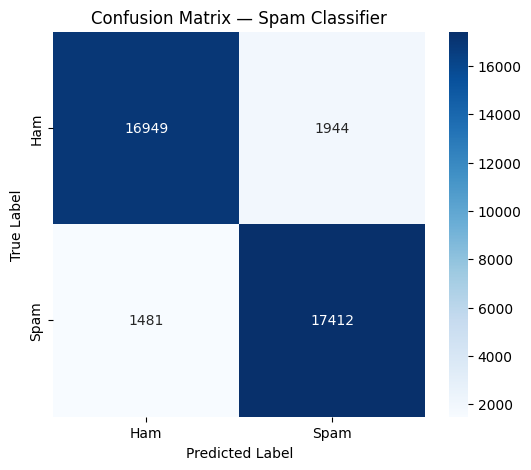

In [23]:
# View model performance results and confusion matrix

print("\n=== Classification report @ threshold 0.5 ===")
print(classification_report(y_test, y_pred, target_names=["Ham", "Spam"]))

print("\n=== Confusion matrix @ threshold 0.5 ===")
cm = confusion_matrix(y_test, y_pred)
cm_labels = ["Ham", "Spam"]

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix — Spam Classifier")
plt.show()

In [24]:
def predict_email(msg: str):
  """
  Predict whether an email message is spam using a Word2Vec + Logistic Regression model.

  Performs preprocessing and embedding steps used during training to a raw email message.
  After which a logistic regression model is trained to produce both a binary prediction
  and spam probability

  Parameters
  ----------
  msg : str
      Raw email or message text to be classified.

  Returns
  -------
  tuple
      A tuple `(label, prob)` where:
      - `label` is the predicted class (1 = spam, 0 = not spam)
      - `prob` is the predicted probability that the message is spam

  """
  # Preprocess the raw message into normalized word tokens
  tokens = preprocess(msg)

  # Convert the token list into a fixed-size sentence embedding and reshape to
  # match the classifier's expected input shape
  vec = embed_sentence(tokens, w2v_model).reshape(1, -1)

  # Predict the binary spam label using the trained classifier
  label = clf.predict(vec)[0]

  # Retrieve the predicted probability of the spam class (class index = 1)
  prob = clf.predict_proba(vec)[0, 1]
  return label, prob

# Model Testing

In [25]:
# Test the model against a long non-spam email
test_email = """
Hi everyone,

I hope you’re all having a productive week so far. I wanted to send a quick update regarding our progress on the Data Integration and Reporting initiative before we meet next Tuesday. The engineering team successfully completed the migration of our reporting pipeline to the new infrastructure over the weekend. Early metrics show about a 40% improvement in query response times, which is great news.

There are still a few open issues that we’ll need to address during the next sprint. Specifically, we need to finalize the API documentation for the external partners and confirm the access permissions for the finance and analytics teams. I’ve added those items to the shared task board for visibility. Please review them before our call and leave any comments or questions directly in the tracker.

Next week’s planning session will be on Tuesday at 10 a.m. in Conference Room B (and on Zoom for remote folks). During that meeting, we’ll discuss deployment timelines, review QA results, and assign tasks for the next iteration. If you can’t make it in person, please let me know so I can ensure you have the dial-in link and the updated slide deck.

Finally, a reminder that the quarterly report drafts are due by end of day Friday. Thank you to everyone who’s already contributed data and charts; it’s made the review process much smoother. If you need any help with formatting or templates, reach out to the documentation team.

Thanks again for all the hard work this month — we’ve made solid progress and are right on track for our March release.

Best,
Alex
Project Lead, Data Systems Team
"""

label, prob = predict_email(test_email)
print("Prediction:", "SPAM" if label == 1 else "HAM", "| spam prob =", prob)

Prediction: HAM | spam prob = 0.012945116670159212


In [26]:
# Test the model against a long spam email
test_email = """
Dear Valued Customer,

Congratulations! You have been selected as one of our exclusive winners in the National Online Rewards Program. Our records show that you have not yet claimed your guaranteed $10,000 cash prize. This is your FINAL opportunity to confirm your eligibility before your entry expires at midnight tonight.

To receive your reward, please verify your information immediately by clicking the secure link below. Once verified, your funds will be transferred directly to your bank account within 24 hours.

CLAIM NOW: https://secure-cashclaim-center.example.com/verify

As part of our verification process, you must confirm your personal details, including your full name, address, and banking information. This information will only be used to validate your identity and process your prize.

Failure to complete this verification step will result in the cancellation of your reward and the selection of an alternate winner.

Act fast — thousands of participants have already claimed their rewards, and our system will automatically close entries after midnight. Don’t miss out on this life-changing opportunity to receive your $10,000 reward!

Warm regards,
The National Rewards Team
support@cashreward-center.example.com

P.S. For security reasons, this message was sent only to verified email subscribers. Please do not share this link. To unsubscribe from future notifications, click here.
"""

label, prob = predict_email(test_email)
print("Prediction:", "SPAM" if label == 1 else "HAM", "| spam prob =", prob)

Prediction: SPAM | spam prob = 0.9217894386964175
